# Import packages

In [84]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
from scipy import stats

from sklearn.preprocessing import StandardScaler


# Functions

- This function is to read csv files saved with the first row that holds the dtypes of all columns. https://stackoverflow.com/questions/50047237/how-to-preserve-dtypes-of-dataframes-when-using-to-csv

In [85]:
def read_csv(path):
    # Read types first line of csv
    dtypes = {key:value for (key,value) in pd.read_csv(path,    
              nrows=1).iloc[0].to_dict().items() if 'date' not in value}

    parse_dates = [key for (key,value) in pd.read_csv(path, 
                   nrows=1).iloc[0].to_dict().items() if 'date' in value]
    # Read the rest of the lines with the types from above
    return pd.read_csv(path, dtype=dtypes, parse_dates=parse_dates, skiprows=[1])

# Load datasets

In [86]:
# read csv using the above function
demographics = read_csv("CustomerDemographic.csv")
addresses = read_csv("CustomerAddress.csv")
transactions = read_csv("Transactions.csv")

In [87]:
demographics.head(1)

customer_id first_name  last_name  ... owns_car  tenure Age
0           1    Laraine  Medendorp  ...      Yes    11.0  67

[1 rows x 12 columns]

In [88]:
addresses.head(1)

customer_id        new_address  postcode state  property_valuation
0           1  60 Morning Avenue      2016   NSW                  10

In [89]:
transactions.head(1)

transaction_id  product_id  ...  standard_cost product_first_sold_date
0               1           2  ...          53.62              2012-12-04

[1 rows x 12 columns]

# Data Transformation

In [90]:
# Simplify job_title into 9 categories

dic = {'Account': 'Professional',
       'Accountant': 'Professional',
       'Technical': 'Professional',
       'Actuary': 'Professional',
       'Analyst': 'Professional',
       'Professor': 'Professional',
       'Teacher': 'Professional',
       'Scientist': 'Professional',
       'Social': 'Community and personal service workers',
       'Advisor': 'Professional',
       'Payment': 'Professional',
       'Specialist': 'Professional',
       'Legal': 'Professional',
       'Paralegal': 'Professional',
       'Biostatistician': 'Professional',
       'Geologist': 'Professional',
       'Statistician': 'Professional',
       'Data': 'Professional',
       'Tech': 'Professional',
       'Programmer': 'Professional',
       'Software': 'Professional',
       'Dental': 'Professional',
       'Health': 'Professional',
       'Nurse': 'Professional',
       'Pharmacist': 'Professional',
       'Pathologist': 'Professional',
       'Therapist': 'Professional',
       'Therapy': 'Professional',
       'Engineer': 'Professional',
       'Chemist': 'Professional',
       'Research': 'Professional',
       'Developer': 'Professional',
       'Marketing': 'Professional',
       'Technician': 'Technician and trade workers',
       'Designer': 'Technician and trade workers',
       'Editor': 'Technician and trade worker',
       'Planner': 'Others',
       'Auditor': 'Others',
       'job_title': 'Others',
       'Office Assistant': 'Others',
       'Unknown': 'Others',
       'Administrative': 'Clerical and admin workers',
       'Administrator': 'Clerical and admin workers',
       'Secretary': 'Clerical and admin workers',
       'Help Desk': 'Clerical and admin workers',
       'Human Resources': 'Clerical and admin workers',
       'Recruiter': 'Clerical and admin workers',
       'Librarian': 'Clerical and admin workers',
       'Administrator': 'Clerical and admin workers', 
       'Manager': 'Manager',
       'Director': 'Manager',
       'Executive': 'Manager',
       'VP': 'Manager',
       'Operator': 'Operators and drivers',
       'Sales': 'Sales workers'}

In [91]:
# Simplify job titles
demographics['job_category'] = demographics['job_title']

for k, v in dic.items():
    demographics['job_category'] = np.where(demographics['job_title'].str.contains(k, case=False), v, demographics['job_category'])

In [92]:
# Categorize customers into generations

# Create year column for binning
demographics['birth_year'] = demographics['DOB'].dt.year

# Bin the birthyear column into generations
bins= [1900, 1945, 1964, 1976, 1995, 2015]
labels = ['Traditionalists','Baby boomers','Gen X','Millennials','Gen Z']
demographics['generation'] = pd.cut(demographics['birth_year'], bins=bins, labels=labels, right=False)

In [93]:
# Bin the Age column into life stage column
bins= [0, 18, 35, 50, 65, 130]
labels = ['Youth','Young Adults','Middle Age','Advanced Age','Retired Age']
demographics['age_group'] = pd.cut(demographics['Age'], bins=bins, labels=labels, right=False)

In [15]:
# scores = [1, 2, 3, 4]

# purchases_scores = pd.qcut(demographics["past_3_years_bike_related_purchases"], q = 4, labels=scores)
# tenure_scores = pd.qcut(demographics["tenure"], q = 4, labels=scores)

# demographics['purchases_score'] = purchases_scores
# demographics['tenure_score'] = tenure_scores

# demographics

In [94]:
# Drop unnessary columns

demographics = demographics[['customer_id', 'gender', 'Age', 'job_category', 'job_industry_category', 'tenure', 'wealth_segment', 'owns_car', 'past_3_years_bike_related_purchases']]

In [95]:
demographics

customer_id   gender  ...  owns_car past_3_years_bike_related_purchases
0              1   Female  ...       Yes                                  93
1              2     Male  ...       Yes                                  81
2              3     Male  ...       Yes                                  61
3              4     Male  ...        No                                  33
4              5   Female  ...       Yes                                  56
...          ...      ...  ...       ...                                 ...
3995        3996   Female  ...        No                                   8
3996        3997   Female  ...       Yes                                  87
3997        3998  Unknown  ...        No                                  60
3998        3999     Male  ...       Yes                                  11
3999        4000     Male  ...        No                                  76

[4000 rows x 9 columns]

In [96]:
addresses = addresses[['customer_id', 'postcode', 'state', 'property_valuation']]

- Create target column from the transactions dataset

In [97]:
# Create a new column for the profit of each transaction

transactions["order_profit"] = transactions.list_price - transactions.standard_cost
transactions.head(1)

transaction_id  product_id  ...  product_first_sold_date order_profit
0               1           2  ...               2012-12-04        17.87

[1 rows x 13 columns]

- Create loyalty_tier as target

In [98]:
# Last date
last_date = transactions["transaction_date"].max()

In [99]:
# Create RFM Modelling scores
rfm_scores = transactions.groupby("customer_id").agg({
    "transaction_date": lambda x: (last_date - x.max()).days,
    "transaction_id": lambda x: len(x),
    "order_profit": lambda x: sum(x)})

In [100]:
# Rename the columns
rfm_scores.columns = ["recency", "frequency", "monetary"]
rfm_scores

recency  frequency     monetary
customer_id                                 
1                  7         11  3018.090000
2                128          3  2226.260000
3                102          7  3290.210000
4                195          2   220.570000
5                 16          6  2394.940000
...              ...        ...          ...
3497              52          3  1648.320000
3498             127          6  3147.330000
3499              51          7  4955.250000
3500             144          6  1785.860000
5034              84          3   269.484972

[3492 rows x 3 columns]

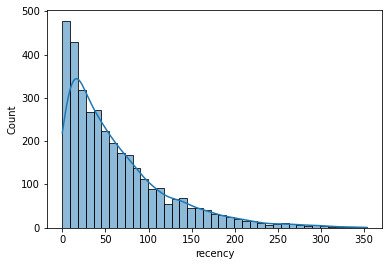

In [101]:
# Plotting the distribution
ax = sns.histplot(rfm_scores["recency"], kde=True)

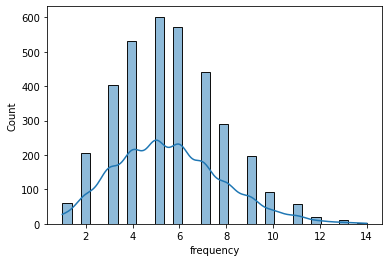

In [102]:
ax = sns.histplot(rfm_scores["frequency"], kde=True)

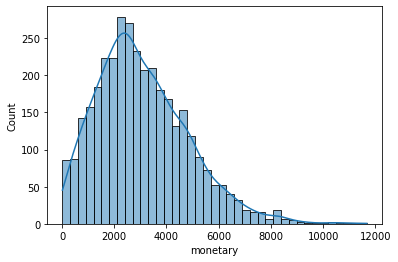

In [103]:
ax = sns.histplot(rfm_scores["monetary"], kde=True)


- Transform data so they follow normal distribution.

In [26]:
rfm_scores['recency'].values[rfm_scores['recency'].values == 0] = 1

Lambda value used for Transformation: 0.27314707636038854


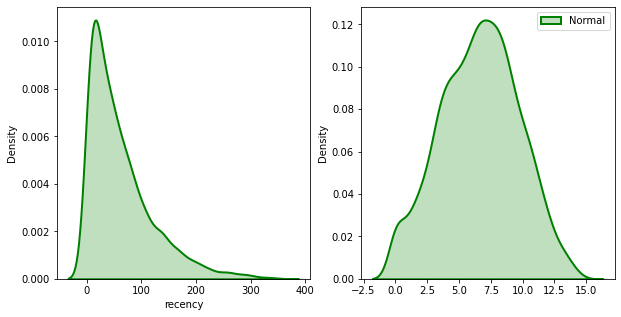

In [27]:

# transform training data & save lambda value

original_recency = rfm_scores["recency"]
fitted_recency, fitted_lambda_recency = stats.boxcox(original_recency)
  
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
  
# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(original_recency, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
  
sns.distplot(fitted_recency, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
  
# adding legends to the subplots
plt.legend(loc = "upper right")
  
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)
  
print(f"Lambda value used for Transformation: {fitted_lambda_recency}")

Lambda value used for Transformation: 0.6023403109226256


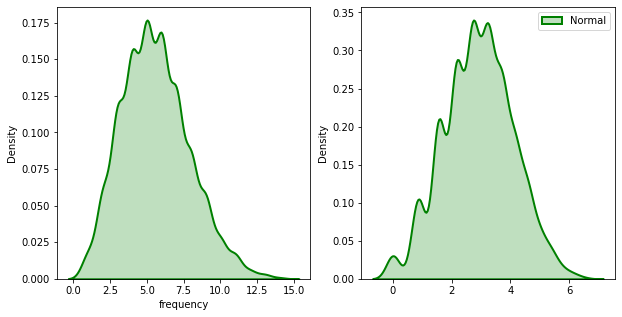

In [28]:

# transform training data & save lambda value

original_freq = rfm_scores["frequency"]
fitted_freq, fitted_lambda_freq = stats.boxcox(original_freq)
  
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
  
# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(original_freq, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
  
sns.distplot(fitted_freq, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
  
# adding legends to the subplots
plt.legend(loc = "upper right")
  
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)
  
print(f"Lambda value used for Transformation: {fitted_lambda_freq}")

Lambda value used for Transformation: 0.5489066493231521


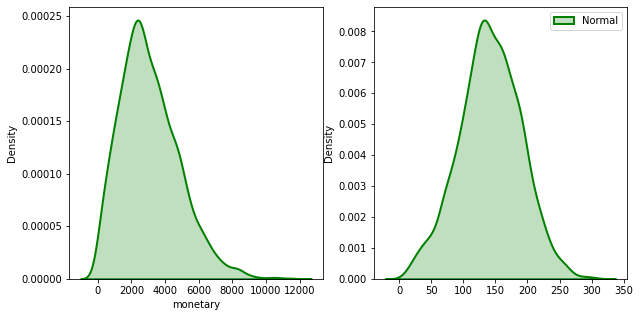

In [29]:

# transform training data & save lambda value

original_monetary = rfm_scores["monetary"]
fitted_monetary, fitted_lambda_monetary = stats.boxcox(original_monetary)
  
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
  
# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(original_monetary, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
  
sns.distplot(fitted_monetary, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
  
# adding legends to the subplots
plt.legend(loc = "upper right")
  
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)
  
print(f"Lambda value used for Transformation: {fitted_lambda_monetary}")

In [30]:
rfm_scores['recency'] = fitted_recency
rfm_scores['frequency'] = fitted_freq
rfm_scores['monetary'] = fitted_monetary

In [104]:
def rfm_tier(value, index, quantile):
    # If the index is recency, then the lower recency, the higher tier
    if value <= quantile[index][0.25]:
        if index == "recency":
            return 1
        else:
            return 4
    elif value <= quantile[index][0.50]:
        if index == "recency":
            return 2
        else:
            return 3
    elif value <= quantile[index][0.75]:
        if index == "recency":
            return 3
        else:
            return 2
    else:
        if index == "recency":
            return 4
        else:
            return 1

In [105]:
# Assigning tier values to R, F, and M for each customer


# Using quantiles to classify customers, setting into 4 segments
quantiles = rfm_scores.quantile([0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

index_list = {"R": "recency", "F": "frequency", "M": "monetary"}
for k, v in index_list.items():
    rfm_scores[k] = rfm_scores[v].apply(rfm_tier, args=(v, quantiles))

rfm_scores

recency  frequency     monetary  R  F  M
customer_id                                          
1                  7         11  3018.090000  1  1  2
2                128          3  2226.260000  4  4  3
3                102          7  3290.210000  4  2  2
4                195          2   220.570000  4  4  4
5                 16          6  2394.940000  1  2  3
...              ...        ...          ... .. .. ..
3497              52          3  1648.320000  3  4  4
3498             127          6  3147.330000  4  2  2
3499              51          7  4955.250000  3  2  1
3500             144          6  1785.860000  4  2  4
5034              84          3   269.484972  3  4  4

[3492 rows x 6 columns]

In [106]:
# Assigning rfm_group to each customer by concatenating R, F, and M
rfm_scores["rfm_group"] = rfm_scores["R"].map(str) + rfm_scores["F"].map(str) + rfm_scores["M"].map(str)

# Calculating the rfm score for each customer by sum them
rfm_scores["rfm_score"] = rfm_scores[["R", "F", "M"]].sum(axis=1)

rfm_scores.head(10)

recency  frequency  monetary  R  F  M rfm_group  rfm_score
customer_id                                                            
1                  7         11   3018.09  1  1  2       112          4
2                128          3   2226.26  4  4  3       443         11
3                102          7   3290.21  4  2  2       422          8
4                195          2    220.57  4  4  4       444         12
5                 16          6   2394.94  1  2  3       123          6
6                 64          5   3946.55  3  3  2       332          8
7                253          3    220.11  4  4  4       444         12
8                 22          9   5364.39  2  1  1       211          4
9                 78          6   2353.11  3  2  3       323          8
10                43          5   3358.28  2  3  2       232          7

In [107]:
# Assigning loyalty tier to each customer
loyalty_tier = ["titanium", "platinum", "gold", "silver"]

# Using pandas quantile cut
score_cuts = pd.qcut(rfm_scores["rfm_score"], q = 4, labels=loyalty_tier)


# Create a new column for the loyalty tier
rfm_scores["loyalty_tier"] = score_cuts
rfm_scores.head(10)

recency  frequency  monetary  ...  rfm_group  rfm_score  loyalty_tier
customer_id                                ...                                    
1                  7         11   3018.09  ...        112          4      titanium
2                128          3   2226.26  ...        443         11        silver
3                102          7   3290.21  ...        422          8      platinum
4                195          2    220.57  ...        444         12        silver
5                 16          6   2394.94  ...        123          6      titanium
6                 64          5   3946.55  ...        332          8      platinum
7                253          3    220.11  ...        444         12        silver
8                 22          9   5364.39  ...        211          4      titanium
9                 78          6   2353.11  ...        323          8      platinum
10                43          5   3358.28  ...        232          7      platinum

[10 rows x 9 columns]

In [108]:
rfm_df = rfm_scores.copy()

In [36]:
# # Create a new column "Average order value"
# transactions["order_profit"] = transactions.list_price - transactions.standard_cost

In [37]:
# # aggregate customer based on brand interaction

# brand_int = transactions.groupby(["customer_id", "brand"], as_index = False)['transaction_id'].mean()
# brand_int = brand_int.rename(columns = {'transaction_id':'total_transactions'})
# brand_int.head(10)

In [38]:
# favourite_brand = []

# # customers_list = np.arange(1, 4001, 1).tolist()
# customers_list = brand_int['customer_id'].unique().tolist()

# for r in customers_list:
#   df_temp = brand_int[brand_int['customer_id'] == r]
#   max_index = df_temp['total_transactions'].argmax()
#   favourite_brand.append(df_temp.iloc[max_index,1])

In [39]:
# transaction_df['favourite_brand'] = favourite_brand

In [40]:
# productline_int = transactions.groupby(["customer_id", "product_line"], as_index = False)['transaction_id'].count()
# productline_int = productline_int.rename(columns = {'transaction_id':'total_transactions'})
# productline_int

In [41]:
# favourite_line= []

# for r in customers_list:
#   df_temp = productline_int[productline_int['customer_id'] == r]
#   max_index = df_temp['total_transactions'].argmax()
#   favourite_line.append(df_temp.iloc[max_index,1])

In [42]:
# transaction_df['favourite_line'] = favourite_line

In [43]:
# product_class_int = transactions.groupby(["customer_id", "product_class"], as_index = False)['transaction_id'].count()
# product_class_int = productline_int.rename(columns = {'transaction_id':'total_transactions'})
# product_class_int

In [44]:
# favourite_class= []

# for r in customers_list:
#   df_temp = product_class_int[product_class_int['customer_id'] == r]
#   max_index = df_temp['total_transactions'].argmax()
#   favourite_class.append(df_temp.iloc[max_index,1])

In [45]:
# transaction_df['favourite_class'] = favourite_class
# transaction_df

In [46]:
# product_size_int = transactions.groupby(["customer_id", "product_size"], as_index = False)['transaction_id'].count()
# product_size_int = product_size_int.rename(columns = {'transaction_id':'total_transactions'})
# product_size_int

In [47]:
# favourite_size= []

# for r in customers_list:
#   df_temp = product_size_int[product_size_int['customer_id'] == r]
#   max_index = df_temp['total_transactions'].argmax()
#   favourite_size.append(df_temp.iloc[max_index,1])

In [48]:
# transaction_df['favourite_size'] = favourite_size
# transaction_df

In [49]:
# online_order_int = transactions.groupby(["customer_id", "online_order"], as_index = False)['transaction_id'].count()
# online_order_int = online_order_int.rename(columns = {'transaction_id':'total_transactions'})
# online_order_int.head(20)

In [50]:
# favourite_method = []

# for r in customers_list:
#   df_temp = online_order_int[online_order_int['customer_id'] == r]
#   max_index = df_temp['total_transactions'].argmax()
#   favourite_method.append(df_temp.iloc[max_index,1])

In [51]:
# transaction_df['favourite_method'] = favourite_method
# transaction_df

# # 1 is online, 0 is offline

In [52]:
# # average order value
# avg_order_value = transactions.groupby(["customer_id"], as_index = False)['list_price'].mean()
# avg_order_value = avg_order_value.rename(columns = {'list_price':'avg_order_value'})
# avg_order_value

In [53]:
# # most profitable customers
# profitable_customers = transactions.groupby(["customer_id"], as_index = False)['order_profit'].sum()
# profitable_customers = profitable_customers.rename(columns = {'order_profit':'total_profit'})
# profitable_customers

In [54]:
demographics['customer_id'] = demographics['customer_id'].astype('int64')
addresses['customer_id'] = addresses['customer_id'].astype('int64')
# transaction_df['customer_id'] = transaction_df['customer_id'].astype('int64')
# avg_order_value['customer_id'] = avg_order_value['customer_id'].astype('int64')
# profitable_customers['customer_id'] = profitable_customers['customer_id'].astype('int64')

In [109]:
#Get all data together

dataframes = [demographics, addresses]
customer_data = reduce(lambda left, right: pd.merge(left, right, on='customer_id', how='left'), dataframes)

In [110]:
customer_data

customer_id   gender  Age  ... postcode state  property_valuation
0              1   Female   67  ...   2016.0   NSW                10.0
1              2     Male   40  ...   2153.0   NSW                10.0
2              3     Male   67  ...      NaN   NaN                 NaN
3              4     Male   59  ...   4211.0   QLD                 9.0
4              5   Female   44  ...   2448.0   NSW                 4.0
...          ...      ...  ...  ...      ...   ...                 ...
3995        3996   Female   45  ...   3977.0   VIC                 6.0
3996        3997   Female   19  ...   2350.0   NSW                 2.0
3997        3998  Unknown   43  ...   2540.0   NSW                 6.0
3998        3999     Male   47  ...   3064.0   VIC                 3.0
3999        4000     Male   29  ...   4511.0   QLD                 6.0

[4000 rows x 12 columns]

In [111]:
customer_data.isna().any()

customer_id                            False
gender                                 False
Age                                    False
job_category                           False
job_industry_category                  False
tenure                                 False
wealth_segment                         False
owns_car                               False
past_3_years_bike_related_purchases    False
postcode                                True
state                                   True
property_valuation                      True
dtype: bool

##**RFM Segmentation**


In [112]:
rfm_df.head()

recency  frequency  monetary  ...  rfm_group  rfm_score  loyalty_tier
customer_id                                ...                                    
1                  7         11   3018.09  ...        112          4      titanium
2                128          3   2226.26  ...        443         11        silver
3                102          7   3290.21  ...        422          8      platinum
4                195          2    220.57  ...        444         12        silver
5                 16          6   2394.94  ...        123          6      titanium

[5 rows x 9 columns]

In [113]:
customer_data.head()

customer_id  gender  Age  ... postcode state  property_valuation
0           1  Female   67  ...   2016.0   NSW                10.0
1           2    Male   40  ...   2153.0   NSW                10.0
2           3    Male   67  ...      NaN   NaN                 NaN
3           4    Male   59  ...   4211.0   QLD                 9.0
4           5  Female   44  ...   2448.0   NSW                 4.0

[5 rows x 12 columns]

In [114]:
rfm_df['recency'].values[rfm_df['recency'].values == 0] = 1
rfm_df['frequency'].values[rfm_df['frequency'].values == 0] = 1

- Transform data to make them more like normal distribution

In [115]:
from scipy import stats
rfm_df_fix = pd.DataFrame()
rfm_df_fix["recency"] = stats.boxcox(rfm_df['recency'])[0]
rfm_df_fix["frequency"] = stats.boxcox(rfm_df['frequency'])[0]
rfm_df_fix["monetary"] = pd.Series(np.cbrt(rfm_df['monetary'])).values
rfm_df_fix.tail()

recency  frequency   monetary
3487   7.111673   1.557523  11.812646
3488  10.087341   3.224869  14.654829
3489   7.054686   3.700178  17.048592
3490  10.567296   3.224869  12.132468
3491   8.619431   1.557523   6.459192

In [116]:
# Initialize the Object
scaler = StandardScaler()

# Fit and Transform The Data
scaler.fit(rfm_df_fix)
rfm_df_normalized = scaler.transform(rfm_df_fix)

# Assert that it has mean 0 and variance 1
print(rfm_df_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(rfm_df_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0. -0.  0.]
[1. 1. 1.]


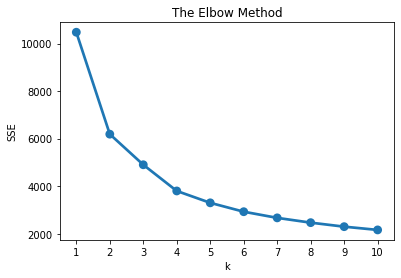

In [117]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_df_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [118]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(rfm_df_normalized)
model.labels_.shape

(3492,)

In [119]:
rfm_df["Cluster"] = model.labels_
rfm_df.groupby('Cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':['mean', 'count']}).round(2)

recency frequency monetary      
           mean      mean     mean count
Cluster                                 
0        119.48      3.60  1722.81  1111
1         47.25      7.66  4626.84  1382
2         20.27      4.87  2422.90   999

In [120]:
# Create the dataframe
df_normalized = pd.DataFrame(rfm_df_normalized, columns=['recency', 'frequency', 'monetary'])
df_normalized['customer_id'] = rfm_df.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['customer_id', 'Cluster'],
                      value_vars=['recency','frequency','monetary'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt

customer_id  Cluster Attribute     Value
0                1        1   recency -1.311229
1                2        0   recency  1.148494
2                3        1   recency  0.878510
3                4        0   recency  1.695585
4                5        2   recency -0.797008
...            ...      ...       ...       ...
10471         3497        0  monetary -0.695373
10472         3498        1  monetary  0.239760
10473         3499        1  monetary  1.027354
10474         3500        0  monetary -0.590145
10475         5034        0  monetary -2.456762

[10476 rows x 4 columns]

In [121]:
gb = df_nor_melt.groupby(["customer_id"], as_index = False)['Cluster'].mean()
gb.head()

customer_id  Cluster
0            1        1
1            2        0
2            3        1
3            4        0
4            5        2

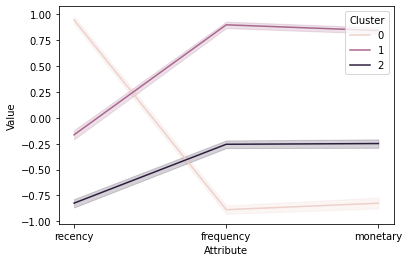

In [122]:
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

- Most recent buys: cluster 2
- Frequent buyers: cluster 1
- Top spenders: Cluster 1

- Cluster 0 dont buy frequently, spend less, and buy the product at the old time. It could be the cluster of unvaluable customers.
- Cluster 1 buy frequently, spend more, and purchased more recently. They are the cuyrrent loyal customers.
- Cluster 2 buy more frequently and spend more than cluster 0, and purchases most recently. They are new customers.

In [123]:
customer_data.columns

Index(['customer_id', 'gender', 'Age', 'job_category', 'job_industry_category',
       'tenure', 'wealth_segment', 'owns_car',
       'past_3_years_bike_related_purchases', 'postcode', 'state',
       'property_valuation'],
      dtype='object')

In [124]:
customers_df = customer_data[['customer_id','gender', 'Age', 'job_category', 'job_industry_category', \
       'tenure', 'wealth_segment', 'owns_car',\
       'past_3_years_bike_related_purchases', 'postcode', 'state',\
       'property_valuation']]

In [128]:
customers_df['customer_id'] = customers_df['customer_id'].astype('int64')

In [131]:
dataframes = [customers_df, gb]
customer_df = reduce(lambda left, right: pd.merge(left, right, on='customer_id', how='left'), dataframes)

In [132]:
customer_df.dropna(inplace=True)

In [133]:
customer_df

customer_id  gender  Age  ... state property_valuation  Cluster
0               1  Female   67  ...   NSW               10.0      1.0
1               2    Male   40  ...   NSW               10.0      0.0
3               4    Male   59  ...   QLD                9.0      0.0
4               5  Female   44  ...   NSW                4.0      2.0
5               6    Male   54  ...   VIC                9.0      1.0
...           ...     ...  ...  ...   ...                ...      ...
3495         3496    Male   35  ...   NSW                9.0      0.0
3496         3497  Female   35  ...   VIC                5.0      0.0
3497         3498  Female   25  ...   VIC                4.0      1.0
3498         3499    Male   42  ...   QLD                9.0      1.0
3499         3500  Female   53  ...   NSW               10.0      0.0

[3487 rows x 13 columns]

In [134]:
# store the customer_id

ids = customer_df.customer_id.copy()

In [135]:
# Get dummies
y = customer_df['Cluster'].values
X = customer_df.drop(['customer_id','Cluster'], axis=1)

X_df = pd.get_dummies(X)
X_df

Age  tenure  ...  state_QLD  state_VIC
0      67    11.0  ...          0          0
1      40    16.0  ...          0          0
3      59     7.0  ...          1          0
4      44     8.0  ...          0          0
5      54    13.0  ...          0          1
...   ...     ...  ...        ...        ...
3495   35    19.0  ...          0          0
3496   35    18.0  ...          0          1
3497   25     5.0  ...          0          1
3498   42     7.0  ...          1          0
3499   53    17.0  ...          0          0

[3487 rows x 35 columns]

In [136]:
# Initialize the Object
scaler = StandardScaler()

scaler.fit(X_df)
X_normalized = scaler.transform(X_df)

# Assert that it has mean 0 and variance 1
print(X_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(X_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0.  0.  0.  0. -0. -0.  0.  0. -0.  0. -0. -0. -0.  0.  0. -0. -0.  0.
 -0. -0.  0. -0.  0. -0. -0. -0.  0. -0.  0. -0.  0.  0. -0. -0.  0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Get data ready

In [149]:
rfm_df

recency  frequency     monetary  ...  rfm_score  loyalty_tier  Cluster
customer_id                                   ...                                  
1                  7         11  3018.090000  ...          4      titanium        1
2                128          3  2226.260000  ...         11        silver        0
3                102          7  3290.210000  ...          8      platinum        1
4                195          2   220.570000  ...         12        silver        0
5                 16          6  2394.940000  ...          6      titanium        2
...              ...        ...          ...  ...        ...           ...      ...
3497              52          3  1648.320000  ...         11        silver        0
3498             127          6  3147.330000  ...          8      platinum        1
3499              51          7  4955.250000  ...          6      titanium        1
3500             144          6  1785.860000  ...         10          gold        0
5034              84          3   269.484972  ...         11        silver        0

[3492 rows x 10 columns]

In [151]:
customers_df = customer_data[['customer_id','gender', 'Age', 'job_category', 'job_industry_category', \
       'tenure', 'wealth_segment', 'owns_car',\
       'past_3_years_bike_related_purchases', 'postcode', 'state',\
       'property_valuation']]

In [153]:
customers_df['customer_id'] = customers_df['customer_id'].astype('int64')

In [156]:
dataframes = [customers_df, rfm_df]
customer_df = reduce(lambda left, right: pd.merge(left, right, on='customer_id', how='left'), dataframes)

In [160]:
customer_df = customer_df[['customer_id', 'gender', 'Age', 'job_category', 'job_industry_category',\
       'tenure', 'wealth_segment', 'owns_car',\
       'past_3_years_bike_related_purchases', 'postcode', 'state',\
       'property_valuation', 'loyalty_tier']]

In [169]:
customer_df.dropna(inplace=True)

In [170]:

ids = customer_df.customer_id.copy()

In [171]:
# Get dummies
y = customer_df['loyalty_tier'].values
X = customer_df.drop(['customer_id','loyalty_tier'], axis=1)

X_df = pd.get_dummies(X)
X_df

Age  tenure  ...  state_QLD  state_VIC
0      67    11.0  ...          0          0
1      40    16.0  ...          0          0
3      59     7.0  ...          1          0
4      44     8.0  ...          0          0
5      54    13.0  ...          0          1
...   ...     ...  ...        ...        ...
3495   35    19.0  ...          0          0
3496   35    18.0  ...          0          1
3497   25     5.0  ...          0          1
3498   42     7.0  ...          1          0
3499   53    17.0  ...          0          0

[3487 rows x 35 columns]

In [172]:
# Initialize the Object
scaler = StandardScaler()

scaler.fit(X_df)
X_normalized = scaler.transform(X_df)

# Assert that it has mean 0 and variance 1
print(X_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(X_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0.  0.  0.  0. -0. -0.  0.  0. -0.  0. -0. -0. -0.  0.  0. -0. -0.  0.
 -0. -0.  0. -0.  0. -0. -0. -0.  0. -0.  0. -0.  0.  0. -0. -0.  0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Algorithm Selection with PyCaret

In [162]:
# !pip install pycaret

In [163]:
# !pip uninstall scikit-learn -y
# !pip install scikit-learn version==0.23.2

In [173]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [174]:
columns = X_df.columns

In [175]:
df = pd.DataFrame(X_normalized, columns=columns)
df

Age    tenure  ...  state_QLD  state_VIC
0     1.890677  0.091177  ...  -0.520358  -0.580993
1    -0.266336  0.955132  ...  -0.520358  -0.580993
2     1.251562 -0.599987  ...   1.921753  -0.580993
3     0.053221 -0.427196  ...  -0.520358  -0.580993
4     0.852115  0.436759  ...  -0.520358   1.721191
...        ...       ...  ...        ...        ...
3482 -0.665783  1.473505  ...  -0.520358  -0.580993
3483 -0.665783  1.300714  ...  -0.520358   1.721191
3484 -1.464677 -0.945569  ...  -0.520358   1.721191
3485 -0.106557 -0.599987  ...   1.921753  -0.580993
3486  0.772226  1.127923  ...  -0.520358  -0.580993

[3487 rows x 35 columns]

In [176]:
df['target'] = y
df

Age    tenure  ...  state_VIC    target
0     1.890677  0.091177  ...  -0.580993  titanium
1    -0.266336  0.955132  ...  -0.580993    silver
2     1.251562 -0.599987  ...  -0.580993    silver
3     0.053221 -0.427196  ...  -0.580993  titanium
4     0.852115  0.436759  ...   1.721191  platinum
...        ...       ...  ...        ...       ...
3482 -0.665783  1.473505  ...  -0.580993    silver
3483 -0.665783  1.300714  ...   1.721191    silver
3484 -1.464677 -0.945569  ...   1.721191  platinum
3485 -0.106557 -0.599987  ...  -0.580993  titanium
3486  0.772226  1.127923  ...  -0.580993      gold

[3487 rows x 36 columns]

In [178]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
df['target_coded'] = labelencoder.fit_transform(df['target'])
df

Age    tenure  ...    target  target_coded
0     1.890677  0.091177  ...  titanium             3
1    -0.266336  0.955132  ...    silver             2
2     1.251562 -0.599987  ...    silver             2
3     0.053221 -0.427196  ...  titanium             3
4     0.852115  0.436759  ...  platinum             1
...        ...       ...  ...       ...           ...
3482 -0.665783  1.473505  ...    silver             2
3483 -0.665783  1.300714  ...    silver             2
3484 -1.464677 -0.945569  ...  platinum             1
3485 -0.106557 -0.599987  ...  titanium             3
3486  0.772226  1.127923  ...      gold             0

[3487 rows x 37 columns]

In [179]:
df = df.drop(['target'], axis=1)

In [3]:
# pip install scikit_learn

In [4]:
# pip install "scikit_learn==0.22.2.post1"

In [180]:
from pycaret.classification import * 

In [182]:
cls = setup( df, target = 'target_coded', imputation_type='iterative')

Description                            Value
0                               session_id                             7280
1                                   Target                     target_coded
2                              Target Type                       Multiclass
3                            Label Encoded           0: 0, 1: 1, 2: 2, 3: 3
4                            Original Data                       (3487, 36)
5                           Missing Values                            False
6                         Numeric Features                                5
7                     Categorical Features                               30
8                         Ordinal Features                            False
9                High Cardinality Features                            False
10                 High Cardinality Method                             None
11                   Transformed Train Set                       (2440, 33)
12                    Transformed Test Set                       (1047, 33)
13                      Shuffle Train-Test                             True
14                     Stratify Train-Test                            False
15                          Fold Generator                  StratifiedKFold
16                             Fold Number                               10
17                                CPU Jobs                               -1
18                                 Use GPU                            False
19                          Log Experiment                            False
20                         Experiment Name                 clf-default-name
21                                     USI                             b42a
22                         Imputation Type                        iterative
23          Iterative Imputation Iteration                                5
24                         Numeric Imputer                             mean
25      Iterative Imputation Numeric Model  Light Gradient Boosting Machine
26                     Categorical Imputer                         constant
27  Iterative Imputation Categorical Model  Light Gradient Boosting Machine
28           Unknown Categoricals Handling                   least_frequent
29                               Normalize                            False
30                        Normalize Method                             None
31                          Transformation                            False
32                   Transformation Method                             None
33                                     PCA                            False
34                              PCA Method                             None
35                          PCA Components                             None
36                     Ignore Low Variance                            False
37                     Combine Rare Levels                            False
38                    Rare Level Threshold                             None
39                         Numeric Binning                            False
40                         Remove Outliers                            False
41                      Outliers Threshold                             None
42                Remove Multicollinearity                            False
43             Multicollinearity Threshold                             None
44                              Clustering                            False
45                    Clustering Iteration                             None
46                     Polynomial Features                            False
47                       Polynomial Degree                             None
48                    Trignometry Features                            False
49                    Polynomial Threshold                             None
50                          Group Features                            False
51                       Feature Selection                            False
52 

In [183]:
# return best model based on AUC
best = compare_models(sort = 'AUC') #default is 'Accuracy'

Model  Accuracy     AUC  Recall   Prec.  \
dt               Decision Tree Classifier    0.2816  0.5097  0.2630  0.2832   
lda          Linear Discriminant Analysis    0.3508  0.5082  0.2517  0.2830   
lr                    Logistic Regression    0.3533  0.5069  0.2522  0.2950   
nb                            Naive Bayes    0.2566  0.5025  0.2564  0.2788   
qda       Quadratic Discriminant Analysis    0.2508  0.5022  0.2538  0.2804   
et                 Extra Trees Classifier    0.2959  0.4988  0.2587  0.2820   
lightgbm  Light Gradient Boosting Machine    0.2914  0.4988  0.2479  0.2679   
rf               Random Forest Classifier    0.3049  0.4985  0.2458  0.2680   
knn                K Neighbors Classifier    0.2684  0.4964  0.2479  0.2700   
ada                  Ada Boost Classifier    0.3348  0.4928  0.2450  0.2647   
gbc          Gradient Boosting Classifier    0.3189  0.4908  0.2463  0.2599   
svm                   SVM - Linear Kernel    0.2975  0.0000  0.2561  0.2453   
ridge                    Ridge Classifier    0.3537  0.0000  0.2525  0.3021   

              F1   Kappa     MCC  TT (Sec)  
dt        0.2818  0.0189  0.0189     0.030  
lda       0.2316  0.0032  0.0054     0.026  
lr        0.2287  0.0034  0.0068     0.506  
nb        0.2538  0.0079  0.0088     0.017  
qda       0.2397  0.0040  0.0047     0.021  
et        0.2829  0.0090  0.0091     0.661  
lightgbm  0.2720 -0.0048 -0.0050     0.369  
rf        0.2662 -0.0077 -0.0081     0.717  
knn       0.2679 -0.0037 -0.0037     0.129  
ada       0.2365 -0.0097 -0.0131     0.179  
gbc       0.2566 -0.0060 -0.0078     1.504  
svm       0.2121  0.0058  0.0044     0.126  
ridge     0.2287  0.0035  0.0076     0.016

In [184]:
# return top 3 models based on 'Accuracy'
top3 = compare_models(n_select = 3)

Model  Accuracy     AUC  Recall   Prec.  \
ridge                    Ridge Classifier    0.3537  0.0000  0.2525  0.3021   
lr                    Logistic Regression    0.3533  0.5069  0.2522  0.2950   
lda          Linear Discriminant Analysis    0.3508  0.5082  0.2517  0.2830   
ada                  Ada Boost Classifier    0.3348  0.4928  0.2450  0.2647   
gbc          Gradient Boosting Classifier    0.3189  0.4908  0.2463  0.2599   
rf               Random Forest Classifier    0.3049  0.4985  0.2458  0.2680   
svm                   SVM - Linear Kernel    0.2975  0.0000  0.2561  0.2453   
et                 Extra Trees Classifier    0.2959  0.4988  0.2587  0.2820   
lightgbm  Light Gradient Boosting Machine    0.2914  0.4988  0.2479  0.2679   
dt               Decision Tree Classifier    0.2816  0.5097  0.2630  0.2832   
knn                K Neighbors Classifier    0.2684  0.4964  0.2479  0.2700   
nb                            Naive Bayes    0.2566  0.5025  0.2564  0.2788   
qda       Quadratic Discriminant Analysis    0.2508  0.5022  0.2538  0.2804   

              F1   Kappa     MCC  TT (Sec)  
ridge     0.2287  0.0035  0.0076     0.016  
lr        0.2287  0.0034  0.0068     0.253  
lda       0.2316  0.0032  0.0054     0.030  
ada       0.2365 -0.0097 -0.0131     0.181  
gbc       0.2566 -0.0060 -0.0078     1.690  
rf        0.2662 -0.0077 -0.0081     0.704  
svm       0.2121  0.0058  0.0044     0.117  
et        0.2829  0.0090  0.0091     0.678  
lightgbm  0.2720 -0.0048 -0.0050     0.309  
dt        0.2818  0.0189  0.0189     0.032  
knn       0.2679 -0.0037 -0.0037     0.133  
nb        0.2538  0.0079  0.0088     0.018  
qda       0.2397  0.0040  0.0047     0.022

https://towardsdatascience.com/customer-segmentation-in-python-9c15acf6f945
https://github.com/erenonal/K-means_customer_segmentation/blob/main/K-means_segmentation.ipynb
https://github.com/Echochi/PyConZA2018/blob/master/Segmentation.ipynb
https://towardsdatascience.com/customer-segmentation-arvato-bertelsmann-project-44e73210a1b7



# Models development

## Models training

## Models evaluation and comparison

## Best model tuning

## Save model

# Apply model on New Customers Dataset